COMP 546 Computer Vision\
HW 2\
Kevin McCoy

In [1]:
# imports

import numpy as np
from scipy import signal
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

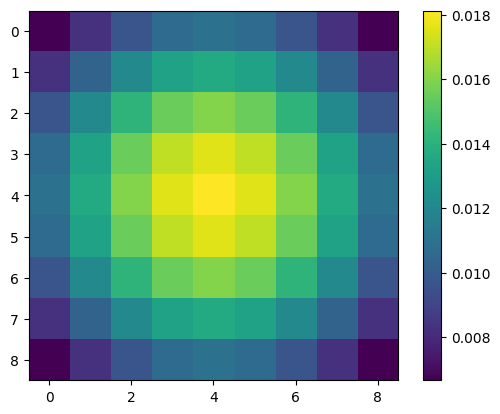

In [ ]:
# Problem 1.1

def gaussian2D(sigma, kernel_size):
    x, y = np.meshgrid(np.linspace(-1, 1, kernel_size[0]),
                       np.linspace(-1, 1, kernel_size[1]))

    sum_squares = np.sqrt(x**2+y**2)

    kernel = np.exp(-(sum_squares**2 / (2.0 * sigma**2)))

    return kernel / sum(sum(kernel))

f = gaussian2D(1, (9,9))

plt.imshow(f, interpolation="nearest", origin="upper")
plt.colorbar()
plt.show()

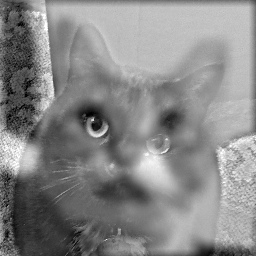

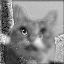

True

In [ ]:
# Problem 1.2

def blur(img, kernel):
    return signal.convolve2d(img, kernel, mode="same")


# Prepare images
A = cv2.imread("/content/mavis.png")
B = cv2.imread("/content/hazel.png")

A = cv2.cvtColor(A, cv2.COLOR_BGR2GRAY)
B = cv2.cvtColor(B, cv2.COLOR_BGR2GRAY)

A = cv2.resize(A, (256, 256)).astype(np.float32)
B = cv2.resize(B, (256, 256)).astype(np.float32)


# cv2_imshow(A)
# cv2_imshow(B)

# cv2_imshow(blur(A, gaussian2D(5, (10, 10))))

kernel = gaussian2D(1, (15, 15))

blur_B = blur(B, kernel)
blur_A = (A-blur(A, kernel))

C = blur_B + blur_A

cv2_imshow(C)

C_down = C[::2, ::2]
C_down = C_down[::2, ::2]

cv2_imshow(C_down)

cv2.imwrite('C.png',C)
cv2.imwrite('c_down.png',C_down)

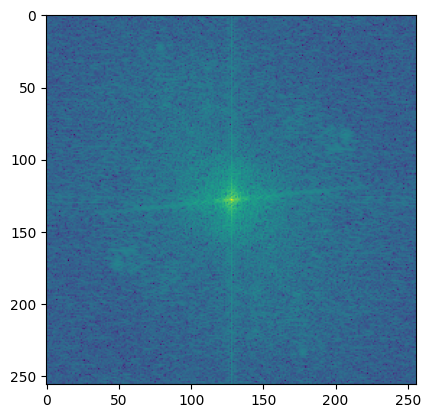

In [ ]:
# Problem 1.3

A_f = np.log(np.abs(np.fft.fftshift(np.fft.fft2(A))))
B_f = np.log(np.abs(np.fft.fftshift(np.fft.fft2(B))))
blur_B_f = np.log(np.abs(np.fft.fftshift(np.fft.fft2(blur_B))))
blur_A_f = np.log(np.abs(np.fft.fftshift(np.fft.fft2(blur_A))))
C_f = np.log(np.abs(np.fft.fftshift(np.fft.fft2(C))))

plt.imshow(A_f)
plt.savefig("A_f.png")
plt.imshow(B_f)
plt.savefig("B_f.png")
plt.imshow(blur_B_f)
plt.savefig("blur_B_f.png")
plt.imshow(blur_A_f)
plt.savefig("blur_A_f.png")
plt.imshow(C_f)
plt.savefig("C_f.png")

In [ ]:
# Problem 1.4

# K1 = I1
# K2 = I4
# K3 = I3
# K4 = I2


In [ ]:
# Problem 1.5

# We can apply fourier transform to both images, and divide the blurred Fourier image by the original Foruier image. This is because convoultion in image space is equivalent to multiplication in Fourier space.


# est = blur_B_f / B_f

# est = np.fft.ifft2(est)

# plt.imshow(np.abs(est))

In [ ]:
# Problem 2.1

def gausspyr(I, n_levels, sigma):

  lst = list([I])

  new_I = I

  for level in range(1, n_levels):

    new_I = blur(new_I, gaussian2D(sigma, (20,20)))

    new_I = new_I[::2, ::2]

    lst = lst + [new_I]

  return lst



In [ ]:
# Problem 2.2

def lappyr(I, n_levels, sigma):

  g_pyra = gausspyr(I, n_levels, sigma)

  lst = list()

  for i in range(n_levels-1):

    x, y = g_pyra[i].shape

    new_img = np.zeros((x,y))

    new_img[::2, ::2] = g_pyra[i+1]

    new_img = blur(new_img, np.array([[0.25, 0.5, 0.25], [0.5, 1, 0.5], [0.25, 0.5, 0.25]]))

    new_img = g_pyra[i] - new_img

    lst = lst + [new_img]

  lst = lst + [g_pyra[-1]]

  return lst


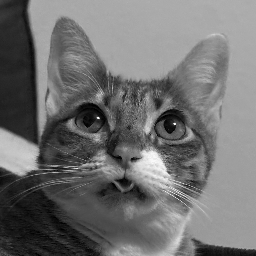

In [ ]:
# Reset images

A = cv2.imread("/content/mavis.png")
B = cv2.imread("/content/hazel.png")

A = cv2.resize(A, (256, 256))
B = cv2.resize(B, (256, 256))

cv2_imshow(B[:,:,0])

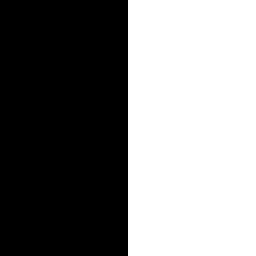

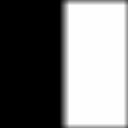

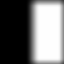

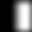

In [ ]:
mask = np.concatenate((np.zeros((256, 128)), np.ones((256, 128))), axis=1).astype(np.uint8)*255

for img in gausspyr(mask, 4, 5):
  cv2_imshow(img)

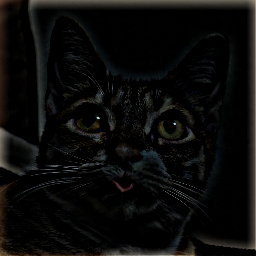

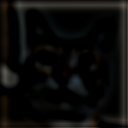

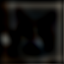

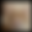

In [ ]:
b_lp = lappyr(B[:,:,0], 4, 1)
g_lp = lappyr(B[:,:,1], 4, 1)
r_lp = lappyr(B[:,:,2], 4, 1)

for i in range(len(g_lp)):
  cv2_imshow(cv2.merge((b_lp[i], g_lp[i], r_lp[i])))

In [ ]:
# Problem 2.3

mask = np.concatenate((np.zeros((256, 128)), np.ones((256, 128))), axis=1)

def blend(A, B, mask):

  A_lp = lappyr(A, 4, 5)
  B_lp = lappyr(B, 4, 5)

  mask_gp = gausspyr(mask, 4, 5)

  new_lst = list()

  for k, I in enumerate(mask_gp):

    new_img = np.multiply(A_lp[k], I) + np.multiply(B_lp[k], 1-I)

    new_lst = new_lst + [new_img]

  return new_lst

combined_AB_lp = blend(A[:,:,0], B[:,:,0], mask)

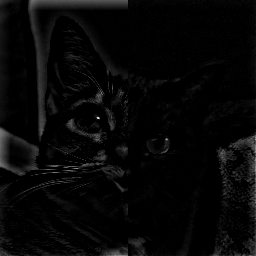

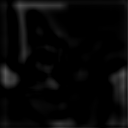

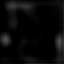

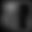

In [ ]:
for img in combined_AB_lp:
  cv2_imshow(img)

In [ ]:
def invert_lp(lp):
  temp_lst = lp

  for k in range(len(lp)-1):

    img = temp_lst[-(k+1)]

    # upsample image
    x, y = img.shape
    new_img = np.zeros((x*2,y*2))
    new_img[::2, ::2] = img
    new_img = blur(new_img, np.array([[0.25, 0.5, 0.25], [0.5, 1, 0.5], [0.25, 0.5, 0.25]]))

    temp_lst[-(k+2)] = temp_lst[-(k+2)] + new_img

  return temp_lst[0]

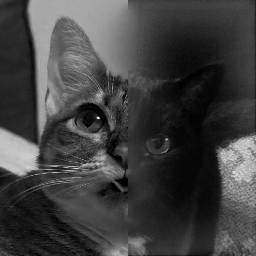

In [ ]:
new_img = invert_lp(combined_AB_lp)

cv2_imshow(new_img)

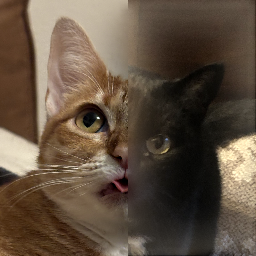

In [ ]:
combined_AB_lp = blend(A[:, :, 0], B[:, :, 0], mask)
b = invert_lp(combined_AB_lp)

combined_AB_lp = blend(A[:, :, 1], B[:, :, 1], mask)
g = invert_lp(combined_AB_lp)

combined_AB_lp = blend(A[:, :, 2], B[:, :, 2], mask)
r = invert_lp(combined_AB_lp)

out_img = cv2.merge((b,g,r))

cv2_imshow(out_img)




In [ ]:
cv2.imwrite('blended.png', out_img)

True

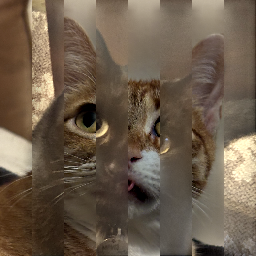

True

In [ ]:
# Problem 2.4

mask = np.concatenate((np.zeros((256, 32)), np.ones((256, 32))), axis=1)

mask = np.tile(mask, 4)

combined_AB_lp = blend(A[:, :, 0], B[:, :, 0], mask)
b = invert_lp(combined_AB_lp)

combined_AB_lp = blend(A[:, :, 1], B[:, :, 1], mask)
g = invert_lp(combined_AB_lp)

combined_AB_lp = blend(A[:, :, 2], B[:, :, 2], mask)
r = invert_lp(combined_AB_lp)

out_img = cv2.merge((b,g,r))

cv2_imshow(out_img)

cv2.imwrite('blended_2.png', out_img)

In [ ]:
# Problem 3.1

import numpy as np
import cv2 as cv
from scipy.signal import butter, filtfilt


def read_video_into_numpy(filename):
  cap = cv.VideoCapture(filename)
  frames = []
  while cap.isOpened():
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
      print("Can't receive frame (stream end?). Exiting ...")
      break

    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    frames.append(frame)

  cap.release()
  video = np.stack(frames, axis=0)#converts to numpy array(T,H,W,C)
  video = np.transpose(video, (1,2,3,0))#(T,H,W,C)->(H,W,C,T)
  return frames


def bandpass_filter(signal, low_cutoff, high_cutoff, fs, order):
  nyquist = 0.5 * fs
  low = low_cutoff / nyquist
  high = high_cutoff / nyquist
  b, a = butter(order, [low, high], btype='band')
  filtered_signal = filtfilt(b, a, signal)

  return filtered_signal


In [ ]:
video = read_video_into_numpy('alice.avi')

Can't receive frame (stream end?). Exiting ...


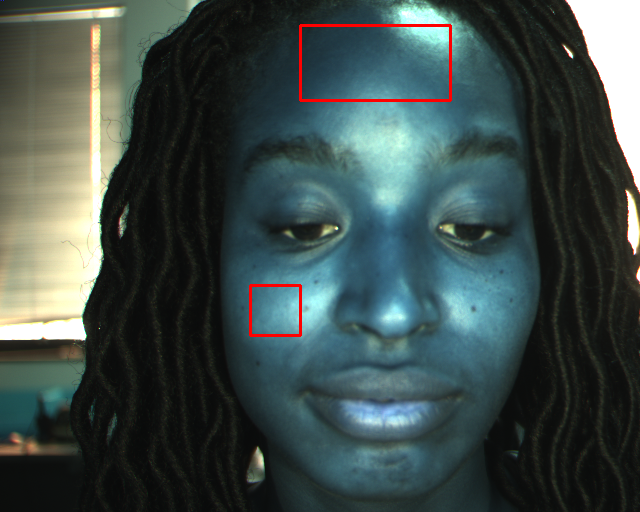

In [ ]:
first_frame = video[0]

# cheek
cv2.rectangle(first_frame, (250, 285), (300, 335), color=(0,0,255), thickness=2)

# forehead
cv2.rectangle(first_frame, (300, 25), (450, 100), color=(0,0,255), thickness=2)

cv2_imshow(first_frame)

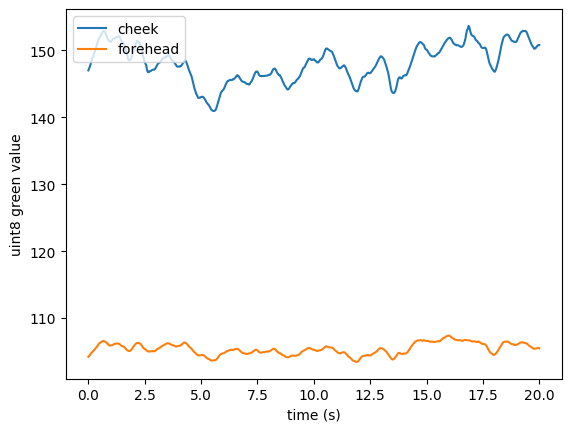

In [ ]:
# Problem 3.2

cheek_green = np.zeros(len(video))

for i, frame in enumerate(video):
  cheek_green[i] = np.mean(frame[285:335, 250:300, 1])


forehead_green = np.zeros(len(video))

for i, frame in enumerate(video):
  forehead_green[i] = np.mean(frame[25:100, 300:450, 1])


plt.plot(np.linspace(0, 20, 600), cheek_green, label="cheek")
plt.plot(np.linspace(0, 20, 600), forehead_green, label="forehead")
plt.xlabel('time (s)')
plt.ylabel('uint8 green value')

plt.legend(loc="upper left")

plt.savefig('ppg.png')

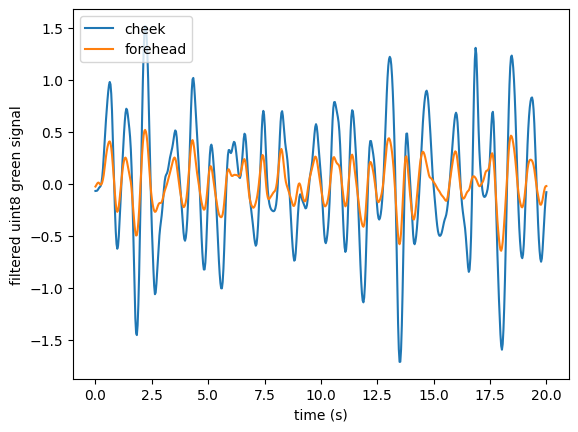

In [ ]:
# Problem 3.3

cheek_filt = bandpass_filter(cheek_green, 0.8, 3, 30, 1)
forehead_filt = bandpass_filter(forehead_green, 0.8, 3, 30, 1)

plt.plot(np.linspace(0, 20, 600), cheek_filt, label="cheek")
plt.plot(np.linspace(0, 20, 600), forehead_filt, label="forehead")

plt.xlabel('time (s)')
plt.ylabel('filtered uint8 green signal')

plt.legend(loc="upper left")

plt.savefig('ppg_2.png')

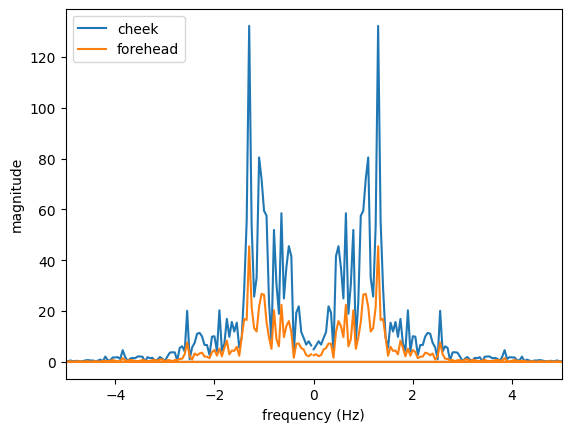

In [ ]:
# Problem 3.4

freq = np.fft.fftfreq(600, d=1/30)

cheek_fft = np.fft.fft(cheek_filt)
plt.plot(freq, np.abs(cheek_fft), label="cheek")

forehead_fft = np.fft.fft(forehead_filt)
plt.plot(freq, np.abs(forehead_fft), label="forehead")

plt.legend(loc="upper left")
plt.xlim((-5, 5))

plt.xlabel('frequency (Hz)')
plt.ylabel('magnitude')

plt.savefig('signal_fft.png')

In [ ]:
# Problem 3.5

from scipy.signal import find_peaks

y = cheek_fft
x = freq



# Find peaks
i_peaks, _ = find_peaks(y)

# Find the index from the maximum peak
i_max_peak = i_peaks[np.argmax(y[i_peaks])]

# Find the x value from that index
x_max = x[i_max_peak]

print(f"The maximum frequency is: {x_max} Hz or {x_max*60} beats per minute.")

The maximum frequency is: 1.3 Hz or 78.0 beats per minute.


/usr/local/lib/python3.10/dist-packages/scipy/signal/_peak_finding.py:265: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)
